In [1]:
# The purpose of this script is to test fully trained models

In [1]:
import sys
sys.path.append('/home3/ebrahim/isr/')
from RNNcell import RNN_one_layer
from datasets import OneHotLetters, OneHotLetters_test
from simulation_one import simulation_one
from run_test_trials import run_test_trials
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import wandb
device = torch.device("cpu")
import seaborn as sns
import scipy
from sklearn.decomposition import PCA
from torch.utils.data import Dataset
import pickle
import pandas as pd
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr

In [2]:
# define functions for later
def softmax(probs):
    return np.exp(probs)/np.sum(np.exp(probs+1e-6))

def sigmoid(probs):
    return 1 / (1 + np.exp(-probs))

def clipper(probs):
    return np.clip(probs, 0, 1.0)

def vec_mag(vec):
    return np.sqrt(np.sum(vec**2))

def pearson_corr(vec1, vec2):
    vec1_centered = vec1 - np.mean(vec1)
    vec2_centered = vec2 - np.mean(vec2)
    vec1_var = np.var(vec1)
    vec2_var = np.var(vec2)
    return np.dot(vec1_centered, vec2_centered)

def cosine_sim(vec1, vec2):
    vec1mag = vec_mag(vec1)
    vec2mag= vec_mag(vec2)
    return round(np.dot(vec1, vec2) / (vec1mag * vec2mag),3)

# define functions for later
def softmax(probs):
    return np.exp(probs)/np.sum(np.exp(probs))

def sigmoid(probs):
    return 1 / (1 + np.exp(-probs))

In [3]:
# load model
base = '/home3/ebrahim/isr/'
modelPATH_arr = ['SGD_stateful_delay_3_1_double_trial']

runPATH_arr = ['ebrahimfeghhi/isr/lf5kod98']

i = 0
try:
    api = wandb.Api()
    run = api.run(runPATH_arr[i])
    config = run.config
    saved_info = torch.load(base + 'saved_models/' +  modelPATH_arr[i]  + '/model_human_temp.pth')
    model = RNN_one_layer(config['input_size'], config['hs'], config['output_size'], noise_std=config['noise_std'],
                            feedback_bool=True, bias=False, alpha_s=config['alpha_s'], plastic=config['plastic'], context=config['context'], 
                            context_size=config['context_size'], h2h_weights=config['h2h_weights'])
    model.load_state_dict(saved_info['model_state_dict'])
    print("LOADED")
except:
    api = wandb.Api()
    run = api.run(runPATH_arr[i])
    config = run.config
    config['input_size'] = config['output_size'] = 27
    config['stateful'] = config['plastic'] = False
    config['delay_start'] = config['delay_middle'] = 0
    config['alpha_s'] = 1.0
    config['test_path_protrusions'] = 'test_set/test_lists_dict_even_odd_12.pkl'
    config['test_path_lists'] = 'test_set/test_lists_dict_small.pkl'
    saved_info = torch.load(base + 'saved_models/' +  modelPATH_arr[i]  + '/model_human.pth')
    model = RNN_one_layer(config['input_size'], config['hs'], config['output_size'], noise_std=config['noise_std'],
                            feedback_bool=True, bias=False, alpha_s=config['alpha_s'])
    model.load_state_dict(saved_info['model_state_dict'])


CommError: Could not find run <Run ebrahimfeghhi/isr/lf5kod98 (not found)>

In [6]:
config['clip_bool']

False

In [20]:
for name, param in model.named_parameters():
    if name == 'h2o.weight':
        h2o = param.detach()
    if name == 'RNN.o2h.weight':
        o2h = param.detach()
    if name == 'RNN.h2h.weight':
        h2h = param.detach()
    if name == 'RNN.i2h.weight':
        i2h = param.detach()

print("Hidden 2 output shape: ", h2o.shape)
print("Output 2 hidden shape: ", o2h.shape)
print("Hidden 2 hidden shape: ", h2h.shape)
print("Input 2 hidden shape: ", i2h.shape)

Hidden 2 output shape:  torch.Size([28, 200])
Output 2 hidden shape:  torch.Size([200, 28])
Hidden 2 hidden shape:  torch.Size([200, 200])
Input 2 hidden shape:  torch.Size([200, 28])


In [21]:
torch.min(h2h)

tensor(-0.5000)

1.0
0.0
1.0
0.0
1.0
0.5
0.0
0.25
0.3333333333333333
0.0
1.0
0.3333333333333333
0.0
0.6666666666666666
0.3333333333333333
1.0
0.0
1.0
0.0
0.6666666666666666
0.0
0.3333333333333333
1.0
0.5
0.75
0.5
0.0
0.3333333333333333
0.5
0.4


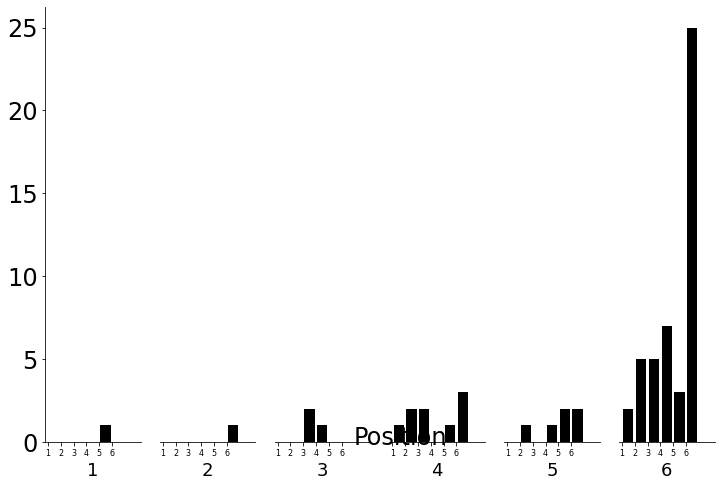

In [23]:
intrusion_graph = {'1': [], '2': [], '3': [], '4': [], '5': [], '6': []}
protrusion_ratio = []

for i in range(30):

    rtt = run_test_trials(model, 0.5)
    rtt.run_model(device, 6, config, base, dict_key='even_odd', protrusions=True, storage_trials=False)
    y_test = rtt.y_test_all
    y_hat_gt = rtt.y_hat_all
    X_test = rtt.X_test_all
    h_stacked = rtt.h_stacked
    rtt.compute_ppr()

    y_hat = rtt.y_hat_recall
    y_test = rtt.y_test_recall

    intrusion_index = 0
    protrusion_index = 0
    for i in range(y_hat.shape[0]):

        if i == 0:
            continue
        
        y_hat_prev = y_hat[i-1]
        y_hat_current = y_hat[i]
        y_test_current = y_test[i]

        # collect indices where y_hat_current equals y_hat_prev
        overlap = np.isin(y_hat_current, y_hat_prev)

        # if there are no matching indices, continue
        if np.sum(overlap) == 0:
            continue 

        matching_indices = np.argwhere(overlap)

        for j in matching_indices:
            
            # if matching index is not in the presented list, it is an intrusion 
            if y_hat_current[j][0] not in y_test_current: 
                prev_intrusion_loc = np.argwhere(y_hat_current[j][0] == y_hat_prev)[0][0] + 1
                intrusion_index+=1
                if j == int(prev_intrusion_loc)-1:
                    protrusion_index+=1
                intrusion_graph[str(j[0]+1)].append(int(prev_intrusion_loc))

    if intrusion_index != 0:
        print(protrusion_index/intrusion_index)
        protrusion_ratio.append(protrusion_index/intrusion_index)

fig, ax = plt.subplots(1,6, sharex=False, sharey=True, figsize=(12,8))
sns.despine()
for i in range(6): 
    ax[i].hist(x = intrusion_graph[str(i+1)], bins=np.arange(1,9,1), 
    density=False, color=(0,0,0), rwidth=.8)
    ax[i].set_xlabel(i+1, fontsize=18)
    ax[i].set_xticks([1,2,3,4,5,6])
    #ax[i].set_yticks([0, .25, .5, .75, 1])
    ax[0].tick_params(axis='y', which='major', labelsize=24)
    ax[i].tick_params(axis='x', labelsize=8)
    if i > 0:
        ax[i].get_yaxis().set_visible(False)
        sns.despine(left=True, ax=ax[i])
#plt.subplots_adjust(wspace=0, hspace=0)
plt.text(-20, -.17, 'Position', fontsize=24)
plt.show()
            

In [24]:
def checkpoint_sim_one(sim_one):
    for ll in range(4, config['max_length']+1, 1):
        sim_one.run_model(device, ll, config)
    return sim_one

In [25]:
sim_one = simulation_one(model, config['max_length'], config['h0_init_val'],
                config['test_list_length'], base='/home3/ebrahim/isr/')

sim_one_updated = checkpoint_sim_one(sim_one)

In [26]:
sim_one_updated.protrusion_rate

0.4444444444444444

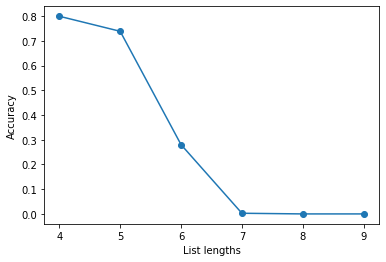

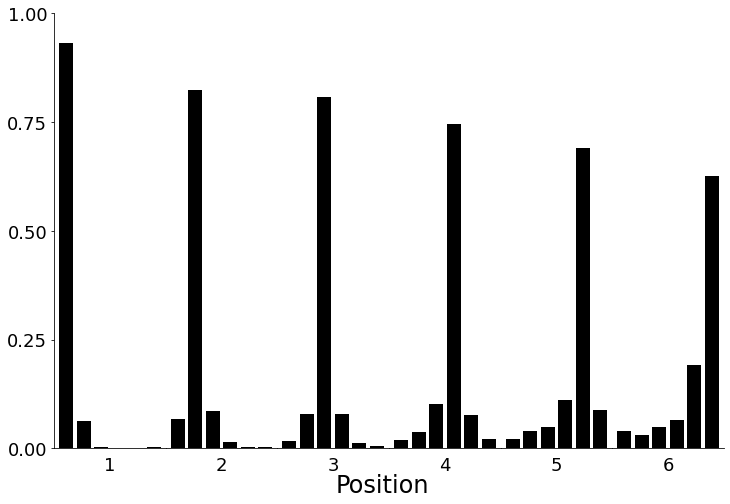

In [9]:
sim_one_updated.figure_six_plot(None, displayMode=True)
sim_one_updated.figure_seven_plot(None, displayMode=True)

In [ ]:
def unit_norm(vec):
    if torch.norm(vec) == 0:
        return vec
    else: 
        return vec / torch.norm(vec)
def rnn_step(h, y, i, t, binding, context_signal):
    
    context_input = unit_norm(context_signal@binding)
    h_new = torch.sigmoid(h@h2h.T + y@o2h.T + i@i2h.T) + context_input
    binding_update = torch.outer(context_signal, h_new)
    update_neurons = torch.argwhere(context_signal==1)[0]
    binding[update_neurons] = binding_update[update_neurons]
    o_new = torch.nn.functional.softmax(h_new@h2o.T,dim=0)
    
    return o_new, h_new, binding

h0 = torch.ones(200)*.5
y0 = torch.zeros(27) * 0.0

y_preds = []
ll=6
binding = torch.zeros((ll, 200))
y_list = []
X_test_no_end_marker = X_test[:, :-1]

for trial in X_test_no_end_marker:
    y_list = []
    for t, input in enumerate(trial):
        context_signal = torch.zeros(ll)
        context_signal[t%ll] = 1
        if t==0:
            y, h, binding= rnn_step(h0, y0, input, t%ll, binding, context_signal)
            y_list.append(y.argmax())   
        else:
            y, h, binding = rnn_step(h, y_hat_onehot, input, t%ll, binding, context_signal)
            y_list.append(y.argmax())
        y_hat_onehot = torch.nn.functional.one_hot(torch.argmax(y, dim=0), 
                                    num_classes=27).to(torch.float32)
    y_preds.append(torch.stack(y_list))


y_hat_all = torch.stack(y_preds)
y_hat = y_hat_all[:, ll:]
y_test = rtt.y_test_recall
ppr = torch.all(torch.eq(y_hat, y_test), dim=1).sum() \
/ y_hat.shape[0]
print(f"PPR is: {ppr}")

In [5]:
import torch
with torch.no_grad():
    print('hey')

hey
